# Treinamento do Classificador de Uso de Máscara
Os passos para treinar nosso classificador são os seguintes:

1.   Carregar o Dataset (imagens e etiquetas)
2.   Pre-procesar as imagens
3.   Gerar conjuntos de treinamento e validação
4.   Carregar a MobileNet, tirando a ultima camada
5.   Acrescentar camadas para nosso problema de classificação de duas classes
6.   Treinar o modelo
7.   Mostrar curvas de treinamento e metricas

Verificar que o tipo de ambiente de execução é **GPU**.
Para mudar o tipo de ambiente de execução, ir para:

`Ambiente de execução -> Alterar tipo de ambiente de execução`

Em Acelerador de hardware, selecionar **GPU**

## Montar o Drive

Executando as seguinte linhas de codigo, podemos montar nosso Google Drive no Colab:

```python
from google.colab import drive
drive.mount('/content/drive')
```
Depois, um link sera apresentado onde temos que accesar para obter um token. Finalmente temos que colar o token nosso Colab para permitir o acceso ao nossos arquivos.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Colabs/Mask_Detection

/content/drive/My Drive/Colabs/Mask_Detection


## Import das bibliotecas necessarias

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from os import walk
from os.path import join
from glob import glob

## Código Principal

### Parâmetros Fixos

Definimos os parâmetros fixos para os experimentos:

*   INIT_LR: taxa de aprendizado
*   BS: tamanho do batch
*   dataset_path: caminho com o dataset criado

In [4]:
INIT_LR = 1e-5
EPOCHS = 50
BS = 32
dataset_path = "dataset"

### Lista de Imagens

Obtemos a lista de imagens de pessoas com e sem máscara, lembrando que temos a seguinte estrutura de pastas:
```
dataset
|
|----with_mask
|
|----without_mask
```
Com a função `walk` podemos iterar sobre as pastas dentro do ***dataset***, para depois listar as imagens com extensão `"jpg"` usando `glob`

```python
list_image_path = []
for root, directories, _ in walk(dataset_path):
  for directory in directories:
    list_image_path = list_image_path + glob(join(root,directory,"*.jpg"))
```



In [9]:
list_image_path = []
for root, directories, _ in walk(dataset_path):
  for directory in directories:
    list_image_path = list_image_path + glob(join(root,directory,"*.jpg"))
print("Total de Imagens: {}".format(len(list_image_path)))

Total de Imagens: 1376


### Pre-procesando os dados

Agora vamos carregar todas as imagens e obter as suas respectivas etiquetas do nome da pasta onde estavam armazenadas
```python
dataset/with_mask/pra1.jpg
```
Usando a função split, conseguimos obter o nome de cada pasta:
```python
label = image_path.split(os.path.sep)[-2]
```
Depois, precisamos carregar cada imagem e pre-procesa ela para treinar o modelo:
```python
  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
```
Finalmente vamos armazenando cada imagem e etiqueta:
```python
  data.append(image)
  labels.append(label)
```
**Isto pode levar muitos minutos devido a quantidade de imagens no dataset**

In [ ]:
data = []
labels = []

for image_path in list_image_path:

  label = image_path.split(os.path.sep)[-2]

  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)
  
  data.append(image)
  labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

Como temos as etiquetas em formato string: `"with_mask"` e `"without_mask"`, precisamos converter elas no formato one-hot-encoding (binario)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Finalmente dividimos o dataset em dois conjuntos para **treinamento** e **validação**

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

### Modelo de classificação

Para fazer o nosso modelo mais robusto, vamos usar aumento de dados, aplicando diferentes tipos de transformações as imagens do nosso dataset

In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

Agora vamos carregar os pesos da MobileNet, tirando a ultima camada

```python
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
```
Depois, acrescentamos camadas para nossa tarefa de classificação binaria
```python
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
```
Finalmente, criamos nosso modelo de classificação
```
model = Model(inputs=baseModel.input, outputs=headModel)
```

In [6]:
# Load MobileNet weights, dropping out the last layer
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Add layers for binary classification
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Create the model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze MobileNet layers
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

### Treinamento do Modelo

Agora vamos treinar o nosso modelo, com a função `compile` definimos o tipo de função de perda, o otimizador e a metrica a ser monitoreada
```python
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
```
Finalmente, com a função `fit`, começamos o treinamento de nosso classificador
```python
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
```

In [ ]:
# compile our model
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/50
34/34 [==============================] - 14s 422ms/step - loss: 0.9350 - accuracy: 0.5309 - val_loss: 0.6298 - val_accuracy: 0.6377
Epoch 2/50
34/34 [==============================] - 14s 403ms/step - loss: 0.7796 - accuracy: 0.6030 - val_loss: 0.4853 - val_accuracy: 0.8116
Epoch 3/50
34/34 [==============================] - 13s 392ms/step - loss: 0.6305 - accuracy: 0.6742 - val_loss: 0.3794 - val_accuracy: 0.8913
Epoch 4/50
34/34 [==============================] - 13s 393ms/step - loss: 0.5134 - accuracy: 0.7687 - val_loss: 0.3037 - val_accuracy: 0.9420
Epoch 5/50
34/34 [==============================] - 14s 397ms/step - loss: 0.4138 - accuracy: 0.8109 - val_loss: 0.2521 - val_accuracy: 0.9457
Epoch 6/50
34/34 [==============================] - 13s 392ms/step - loss: 0.3957 - accuracy: 0.8277 - val_loss: 0.2129 - val_accuracy: 0.9565
Epoch 7/50
34/34 [==============================] - 13s 393ms/step - loss: 0.3222 - accuracy

### Visualiando resultados do treinamento

Com a função `predict`, podemos evaluar o modelo, neste caso usamos o conjunto de validação e obtemos a classe prevista:
```python
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
```
Salvamos o modelo treinado:
```
model.save("model.h5", save_format="h5")
```


Finalmente apresentamos a matriz de confusão e a grafica de treinamento


[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276

[INFO] saving mask detector model...


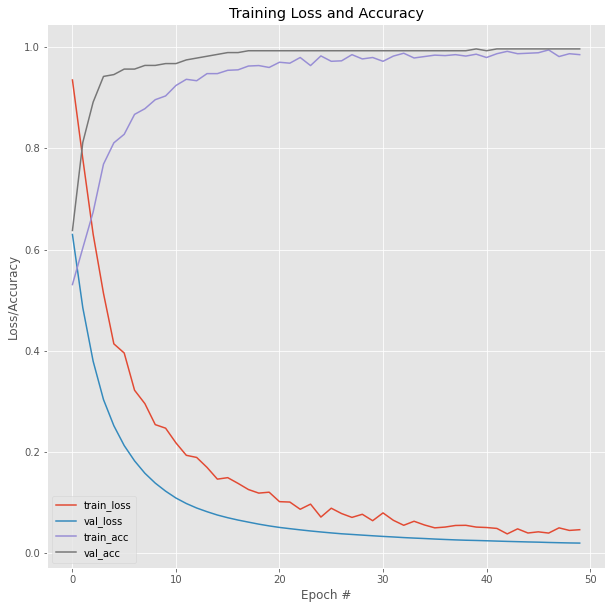

In [ ]:
print("evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# ssave the model
print("saving mask detector model...")
model.save("model.h5", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training.png")